In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBBSSBSS'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0 ******* Update Version ******


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [12]:
STAT['PRCP']['eigval']

array([ 15960.01881805,   6657.7408489 ,   6286.85361933,   6141.7238754 ,
         5483.32178389,   5428.76937205,   4865.07675284,   4718.80737211,
         4660.99994576,   4609.92325277,   4445.95363703,   4132.818507  ,
         4032.23342309,   3864.05070976,   3769.345275  ,   3737.74448635,
         3549.35794043,   3354.39796373,   3251.92161521,   3207.61483779,
         3109.29011886,   3002.79263492,   2982.64010451,   2932.67737568,
         2873.44121229,   2802.63453893,   2787.62220297,   2755.37203168,
         2696.30773257,   2628.00789918,   2559.43134858,   2534.88316957,
         2433.09967054,   2392.51642728,   2379.0709146 ,   2331.64046515,
         2319.89763017,   2257.76849024,   2239.12159369,   2180.54264106,
         2163.75620991,   2128.88651115,   2070.2677672 ,   2046.9395839 ,
         2025.86534712,   1972.4716808 ,   1958.6892607 ,   1946.24632058,
         1881.22461156,   1847.42060438,   1833.4625323 ,   1763.64383823,
         1806.44170483,  

## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1905.9| 42.4167|-105.3667|       SNWD|USC00483073|     0|[5C 5C 5C 5C 5C 5...|1953.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       SNWD|USC00483073|     0|[F0 5B F0 5B F0 5...|1954.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       SNWD|USC00483073|    10|[C0 58 C0 58 C0 5...|1955.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       SNWD|USC00483073|     0|[00 00 00 00 00 0...|1956.0|SBBSSBSS|
|   1905.9| 42.4167|-105.3667|       SNWD|USC00483073|     6|[58 5A 58 5A 58 5...|1957.0|SBBSSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### T-Test on the data based on period (before 1980 or 1980 and after)

In [7]:
pandas_df = df.toPandas()
pandas_df

,elevation,latitude,longitude,measurement,station,undefs,vector,year,label
0,1905.9,42.4167,-105.3667,SNWD,USC00483073,0,"[92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 144, ...",1953.0,SBBSSBSS
1,1905.9,42.4167,-105.3667,SNWD,USC00483073,0,"[240, 91, 240, 91, 240, 91, 240, 91, 40, 91, 8...",1954.0,SBBSSBSS
2,1905.9,42.4167,-105.3667,SNWD,USC00483073,10,"[192, 88, 192, 88, 192, 88, 240, 87, 88, 90, 1...",1955.0,SBBSSBSS
3,1905.9,42.4167,-105.3667,SNWD,USC00483073,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1956.0,SBBSSBSS
4,1905.9,42.4167,-105.3667,SNWD,USC00483073,6,"[88, 90, 88, 90, 88, 90, 88, 90, 88, 90, 88, 9...",1957.0,SBBSSBSS
5,1943.1,41.5833,-109.2167,SNWD,USC00487840,4,"[96, 82, 192, 88, 192, 88, 144, 89, 192, 88, 9...",1949.0,SBBSSBSS
6,1943.1,41.5833,-109.2167,SNWD,USC00487840,2,"[0, 0, 96, 82, 192, 84, 192, 84, 192, 84, 96, ...",1950.0,SBBSSBSS
7,1943.1,41.5833,-109.2167,SNWD,USC00487840,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1951.0,SBBSSBSS
8,1943.1,41.5833,-109.2167,SNWD,USC00487840,5,"[96, 82, 96, 82, 96, 82, 96, 82, 96, 82, 96, 8...",1952.0,SBBSSBSS
9,1943.1,41.5833,-109.2167,SNWD,USC00487840,0,"[96, 82, 96, 82, 64, 78, 0, 0, 0, 0, 0, 0, 0, ...",1953.0,SBBSSBSS


In [8]:
day_number_name_dictionary = {}
for i in range(1, 366):
    day_number_name_dictionary[str(i)] = []

In [9]:
for i in range(len(pandas_df['vector'])):
    for j in range(365):
        day_number_name_dictionary[str(j + 1)].append(pandas_df['vector'][i][j])

In [10]:
import pandas as pd
df_SNWD = pd.DataFrame(day_number_name_dictionary)
df_SNWD

,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
0,92,92,100,138,99,242,98,90,98,38,...,97,246,96,196,96,94,96,42,96,94
1,240,91,86,192,84,96,82,96,82,64,...,0,0,0,0,0,0,0,0,0,96
2,192,90,96,144,96,94,96,94,96,94,...,95,192,94,192,94,88,94,94,96,196
3,0,0,87,96,86,192,84,192,84,0,...,87,144,89,240,87,240,87,240,87,240
4,88,90,0,0,0,96,82,0,0,0,...,78,0,0,0,0,0,0,0,0,0
5,96,88,0,0,0,0,0,0,0,0,...,82,64,78,0,0,0,0,0,0,0
6,0,84,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,78,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,64
8,96,82,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,96,0,78,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,64,78,64


In [14]:
#computing the average snowfall for each row
mean_list = []
for i in range(len(pandas_df['vector'])):
    mean_list.append(mean(pandas_df['vector'][i]))
    
pandas_df['average snowfall'] = mean_list

In [18]:
#The earliest year to latest year; because of the data, we get a median year of 1980
min(pandas_df['year']), max(pandas_df['year'])

(1948.0, 2012.0)

In [21]:
#We break the data frame according to the median for the t-test
pandas_df_one = pandas_df[pandas_df['year'] < 1980]
pandas_df_two = pandas_df[1980 <= pandas_df['year']]

In [23]:
type(list(pandas_df_one['average snowfall']))

list

In [26]:
#Performing a t-test on the two sets
#The following function returns the following tuple: (t-statistic, p-value)

from scipy.stats import ttest_ind
ttest_ind(list(pandas_df_one['average snowfall']), list(pandas_df_two['average snowfall']), equal_var = False)

Ttest_indResult(statistic=-1.7533915399022877, pvalue=0.079781307925750805)

Since the above p-value is .0798, we keep the null. More plainly, there is no significant difference in average daily snowfall between before and after 1980.

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

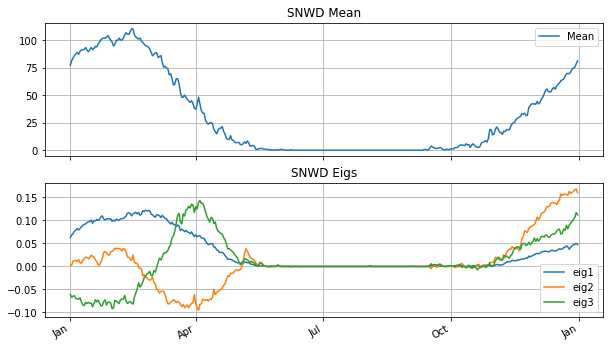

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

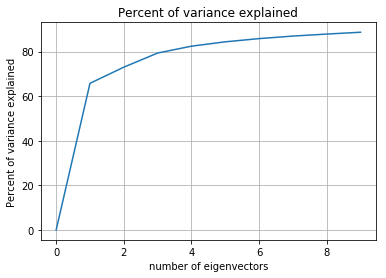

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1245
after filter 584


In [12]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [13]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [14]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

Exception: could not open socket

In [ ]:
plot_recon_grid(rows)

In [16]:
df3.sort?

In [17]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+-----------------+-------------------+
|          coeff_2|              res_2|
+-----------------+-------------------+
|3172.996639613068|0.06795621118369945|
|3076.774322244906| 0.0817973770724431|
|2498.093754725458|0.08831505129810768|
|2484.242555090361|0.06379113165553942|
+-----------------+-------------------+
only showing top 4 rows



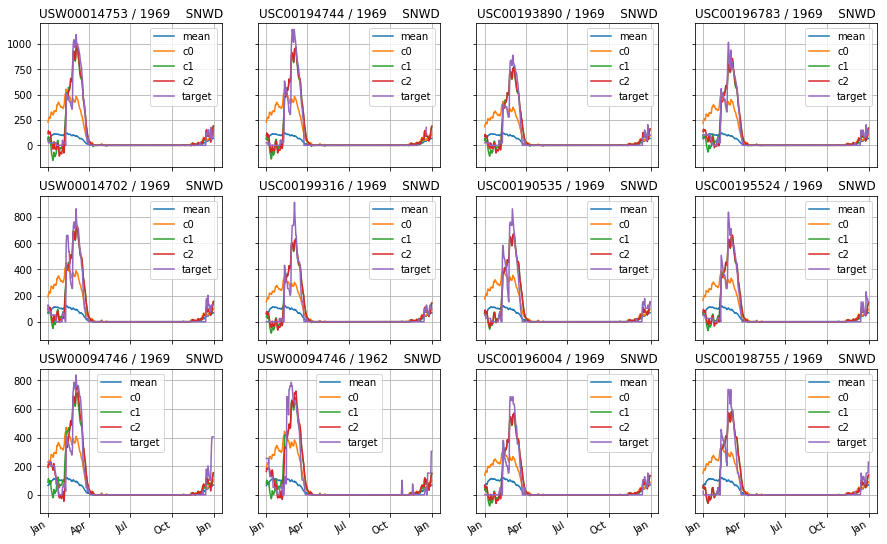

In [18]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.803966043203
residual normalized norm  after mean + top eigs: [ 0.60836185  0.06795621  0.05472411]


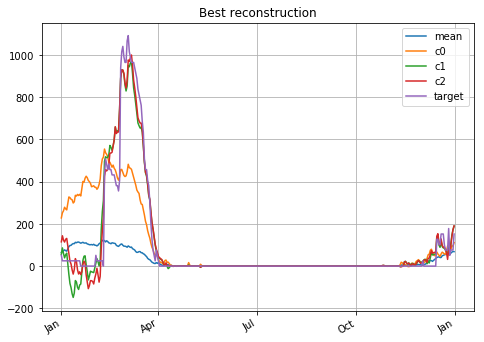

In [19]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [15]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

In [16]:
plot_CDF('res_2')

Exception: could not open socket

In [ ]:
plot_CDF('coeff_2')

In [ ]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [ ]:
!du -sh $data_dir/*.parquet